In [1]:
from keras.datasets import boston_housing

# load data
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

# 404 training examples, 102 test samples, and 13 numerical features
print(train_data.shape, train_targets.shape, test_data.shape, test_targets.shape)

# median values of owner-occupied homes, in thousands of dollars
print(train_targets[:10])

Using TensorFlow backend.


(404, 13) (404,) (102, 13) (102,)
[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4]


In [2]:
"""
Prepare Data

1. It would be problematic to feed into a neural network values that all take wildly different ranges. The network might be able to
   automatically adapt to such heterogeneous data, but it would definitely make learning more difficult. A widespread best practice to
   deal with such data is to do feature-wise normalization: for each feature in the input data (a column in the input data matrix),
   you subtract the mean of the feature and divide by the standard deviation, so that the feature is centered around 0 and has a unit
   standard deviation.

2. Note that the quantities used for normalizing the test data are computed using the training data. You should never use in your workflow
   any quantity computed on the test data, even for something as simple as data normalization.
"""
mean = train_data.mean(axis=0)
train_data -= mean

std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [3]:
"""
Building the network

1. Because so few samples are available, you’ll use a very small network with two hidden layers, each with 64 units. In general,
   the less training data you have, the worse overfitting will be, and using a small network is one way to mitigate overfitting.

2. The network ends with a single unit and no activation (it will be a linear layer). This is a typical setup for scalar regression
   (a regression where you’re trying to predict a single continuous value). Applying an activation function would constrain the range
   the output can take; for instance, if you applied a sigmoid activation function to the last layer, the network could only learn to
   predict values between 0 and 1. Here, because the last layer is purely linear, the network is free to learn to predict values
   in any range.

3. Note that you compile the network with the mse loss function—mean squared error, the square of the difference between the predictions
   and the targets. This is a widely used loss function for regression problems. You’re also monitoring a new metric during training:
   mean absolute error (MAE). It 's the absolute value of the difference between the predictions and the targets. 
"""
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [8]:
"""
Validating using K-fold validation

1. To evaluate your network while you keep adjusting its parameters (such as the number of epochs used for training), you could
   split the data into a training set and a validation set, as you did in the previous examples. But because you have so few data points,
   the validation set would end up being very small (for instance, about 100 examples). As a consequence, the validation scores might
   change a lot depending on which data points you chose to use for validation and which you chose for training: the validation
   scores might have a high variance with regard to the validation split. This would prevent you from reliably evaluating your model.

2.  The best practice in such situations is to use K-fold cross-validation. It consists of splitting the available data into K partitions
    (typically K = 4 or 5), instantiating K identical models, and training each one on K – 1 partitions while evaluating on the remaining
    partition. The validation score for the model used is then the average of the K validation scores obtained. In terms of code,
    this is straightforward.
"""
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epoch = 500
all_scores = []
all_mae_histories = []

for i in range(k):
    print('Processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                         train_data[(i + 1)* num_val_samples:]],
                                        axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                            train_targets[(i + 1)* num_val_samples:]],
                                           axis=0)
    model = build_model()
    history= model.fit(partial_train_data,
                       partial_train_targets,
                       validation_data=(val_data, val_targets),
                       epochs=num_epoch,
                       batch_size=1,
                       verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

print(all_scores)
print(np.mean(all_scores))

Processing fold # 0
Processing fold # 1
Processing fold # 2
Processing fold # 3
[2.511338200899634, 3.138691569318866, 3.023887015805386, 2.9347212385423114]
2.9021595061415493


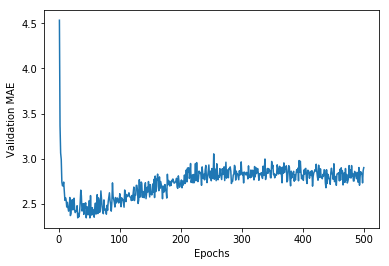

In [10]:
import matplotlib.pyplot as plt

average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epoch)]

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

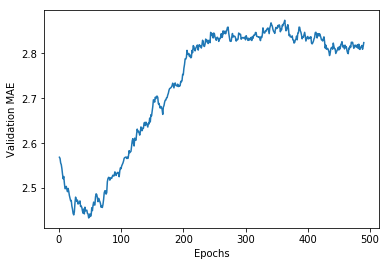

In [11]:
# validation MAE stops improving significantly after 80 epochs. Past that point, you start overfitting.
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [12]:
# Training the final model

model = build_model()
model.fit(train_data,
          train_targets,
          epochs=80,
          batch_size=16,
          verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
print(test_mse_score, test_mae_score)

102/102 [==============================] - 0s 750us/step
17.45998098336014 2.6323786810332654


In [ ]:
"""
Summaries

1. Regression is done using different loss functions than what we used for classification. Mean squared error (MSE) is a loss function
   commonly used for regression.

2. Similarly, evaluation metrics to be used for regression differ from those used for classification; naturally, the concept of accuracy
   doesn’t apply for regression. A common regression metric is mean absolute error (MAE).

3. When features in the input data have values in different ranges, each feature should be scaled independently as a preprocessing step.

4. When there is little data available, using K-fold validation is a great way to reliably evaluate a model.

5. When little training data is available, it’s preferable to use a small network with few hidden layers (typically only one or two),
   in order to avoid severe overfitting. 
"""